In [ ]:

import os
import shutil

def collect_edge_images(path):
    edge_mask_dir = os.path.join(path, 'edgeMask')
    os.makedirs(edge_mask_dir, exist_ok=True)

    for subdir in os.listdir(path):
        subpath = os.path.join(path, subdir)
        if os.path.isdir(subpath):
            output_dir = os.path.join(edge_mask_dir, subdir)
            os.makedirs(output_dir, exist_ok=True)

            for filename in os.listdir(subpath):
                if 'edge' in filename and filename.endswith('.png'):
                    src = os.path.join(subpath, filename)
                    dst = os.path.join(output_dir, filename)
                    shutil.copyfile(src, dst)
                    print(f"Copied {src} -> {dst}")


In [ ]:

from PIL import Image
import os

def convert_png_to_tif_in_edge_mask(path):
    edge_mask_dir = os.path.join(path, 'edgeMask')
    for subfolder in os.listdir(edge_mask_dir):
        subfolder_path = os.path.join(edge_mask_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.png'):
                    png_path = os.path.join(subfolder_path, filename)
                    tif_name = os.path.splitext(filename)[0] + '.tif'
                    tif_path = os.path.join(subfolder_path, tif_name)

                    with Image.open(png_path) as img:
                        img.save(tif_path)
                        print(f"Converted {png_path} -> {tif_path}")


In [ ]:

import os
import shutil

def collect_edge_images(path):
    edge_mask_dir = os.path.join(path, 'edgeMask')
    os.makedirs(edge_mask_dir, exist_ok=True)


    for subdir in os.listdir(path):
        subpath = os.path.join(path, subdir)
        if os.path.isdir(subpath):
            output_dir = os.path.join(edge_mask_dir, subdir)
            os.makedirs(output_dir, exist_ok=True)

 
            for filename in os.listdir(subpath):
                if 'edge' in filename and filename.endswith('.png'):
                    src = os.path.join(subpath, filename)
                    dst = os.path.join(output_dir, filename)
                    shutil.copyfile(src, dst)
                    print(f"Copied {src} -> {dst}")


,Frame Index,Mean Arrow Length,Max Arrow Length,Mean Angle (°),Angle Std Dev (°),Dominant Angle Range
0,0,0.0,0.0,0.0,0.0,0° to 30°
1,1,0.0,0.0,0.0,0.0,0° to 30°
2,2,0.0,0.0,0.0,0.0,0° to 30°
3,3,0.0,0.0,0.0,0.0,0° to 30°
4,4,0.0,0.0,0.0,0.0,0° to 30°
...,...,...,...,...,...,...
234,234,0.0,0.0,0.0,0.0,0° to 30°
235,235,0.0,0.0,0.0,0.0,0° to 30°
236,236,0.0,0.0,0.0,0.0,0° to 30°
237,237,0.0,0.0,0.0,0.0,0° to 30°


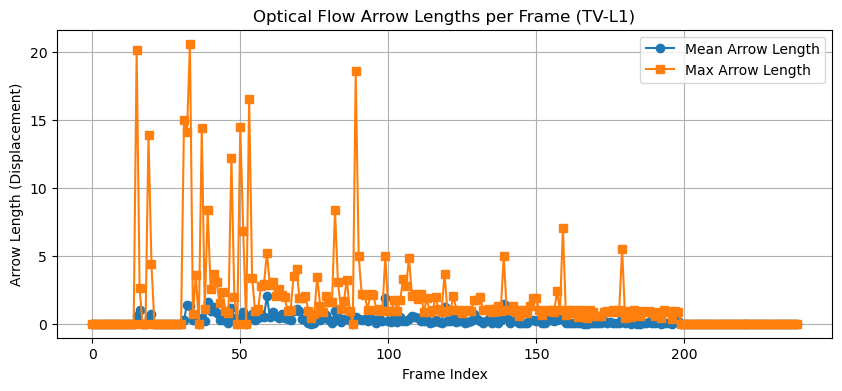

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage import io
from skimage import registration as skr
from skimage.exposure import rescale_intensity
import os


astack = io.imread('masks.tif')


gray_stack = np.zeros((astack.shape[0], astack.shape[1], astack.shape[2]), dtype=np.float32)
for i in range(astack.shape[0]):
    gray = rgb2gray(astack[i]) if astack[i].ndim == 3 else astack[i]
    gray_stack[i] = rescale_intensity(gray, out_range=(0, 1))



FIGSIZE = (8, 8)
nvec = 20
nr, nc = gray_stack.shape[1:]
step = max(nr // nvec, nc // nvec)
figdims = (int(plt.rcParams['figure.dpi'] * FIGSIZE[0]), int(plt.rcParams['figure.dpi'] * FIGSIZE[1]))
flow_stack = np.empty((gray_stack.shape[0]-1, figdims[1], figdims[0]))


mean_arrow_lengths = []
max_arrow_lengths = []
mean_angles_deg = []
std_angles_deg = []
dominant_angle_ranges = []


angle_bins = np.arange(-180, 181, 30)


save_dir = 'flow_stack_images_tvl1'
os.makedirs(save_dir, exist_ok=True)


for slice_index in range(gray_stack.shape[0]-1):
    flow = skr.optical_flow_tvl1(gray_stack[slice_index], gray_stack[slice_index+1])
    v, u = flow[0], flow[1]

    flow_magnitude = np.sqrt(u ** 2 + v ** 2)
    mean_arrow_lengths.append(np.mean(flow_magnitude))
    max_arrow_lengths.append(np.max(flow_magnitude))


    angles_rad = np.arctan2(v, u)
    angles_deg = np.degrees(angles_rad)
    mean_angles_deg.append(np.mean(angles_deg))
    std_angles_deg.append(np.std(angles_deg))

  
    hist, bins = np.histogram(angles_deg, bins=angle_bins)
    dominant_idx = np.argmax(hist)
    dominant_range = f"{bins[dominant_idx]}° to {bins[dominant_idx+1]}°"
    dominant_angle_ranges.append(dominant_range)


    y, x = np.mgrid[:nr:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    fig = plt.figure(figsize=FIGSIZE, frameon=False, tight_layout=True)
    plt.imshow(gray_stack[slice_index], cmap='gray')
    plt.quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale=0.25, scale_units='xy', lw=3)
    plt.gca().set_axis_off()

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    rgba = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    flow_stack[slice_index] = rgba[:, :, 1]

    fig.savefig(f"{save_dir}/slice_{slice_index:03d}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)


summary_df = pd.DataFrame({
    'Frame Index': list(range(len(mean_arrow_lengths))),
    'Mean Arrow Length': mean_arrow_lengths,
    'Max Arrow Length': max_arrow_lengths,
    'Mean Angle (°)': mean_angles_deg,
    'Angle Std Dev (°)': std_angles_deg,
    'Dominant Angle Range': dominant_angle_ranges
})


from IPython.display import display
display(summary_df)


summary_df.to_csv('arrow_direction_summary.csv', index=False)


plt.figure(figsize=(10, 4))
plt.plot(mean_arrow_lengths, label='Mean Arrow Length', marker='o')
plt.plot(max_arrow_lengths, label='Max Arrow Length', marker='s')
plt.xlabel('Frame Index')
plt.ylabel('Arrow Length (Displacement)')
plt.title('Optical Flow Arrow Lengths per Frame (TV-L1)')
plt.legend()
plt.grid(True)
plt.show()
